<a href="https://colab.research.google.com/github/htariq1/projects/blob/main/Image_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using K-means Clustering for Image Compression
## By Hassan Tariq

## Purpose
To use k-means and k-means++ algorithms to identify k cluster centers and an assignment of vectors, one to each cluster, that minimizes the sum of squared distance from the vectors to their corresponding cluster centers. I will experiment with this in the context of images.  An image consists of pixels.  Each pixel has a red, green and blue value, which are typically represented with 8 bit unsigned integers.  This means every color has a value between 0 and 255.  If we represent these values explicitly, we need 24 bits for every pixel in the image.  If our image has N pixels, we need 24N bits.

But suppose our image only contained 256 distinct colors.  In that case, we could represent the image with much less space.  We would just need a table of 256 colors.  Then, for every pixel we could describe its color with an index into this table.  Representing such a table requires 256*24 bits, while representing the indices requires 8N bits. 

But real images don't have 256 different colors, they may have millions of different colors.  But many of these colors are pretty similar, so we can often approximate an image with a small number of colors.  We want to do this with as little distortion of the true colors as possible.  K-means is perfect for this.  The cluster centers will be the colors we put in the table.  The assignment of pixels to cluster centers will tell us what color to use in the approximate image for each pixel.  And the objective function of K-means is a way of saying we want to find the colors for the table and a way of assigning pixels to these colors that minimizes the distortion of the image.

## Importing Libraries and Downloading Images


I begin by importing some standard libs.  cv2 is OpenCV, a standard library used for computer vision.

In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

Google drive link to download the images that I will be using:
- [f2004.jpg](https://drive.google.com/file/d/1H6N3zCcyPnw0scyAKisl0tF1p_zHDthm/view?usp=sharing)
- [f2004_small.jpg](https://drive.google.com/file/d/1BqzqpjsguhoE5nSoufy2tvzIqPsts03A/view?usp=sharing)

Next, I select the files to load on my computer.

In [3]:
from google.colab import files
uploaded = files.upload() 

Saving f2004_small.jpg to f2004_small.jpg
Saving f2004.jpg to f2004.jpg


The next code reads the images into Python and displays them.

In [4]:
imgsmall = cv2.imread('f2004_small.jpg')
img = cv2.imread('f2004.jpg')

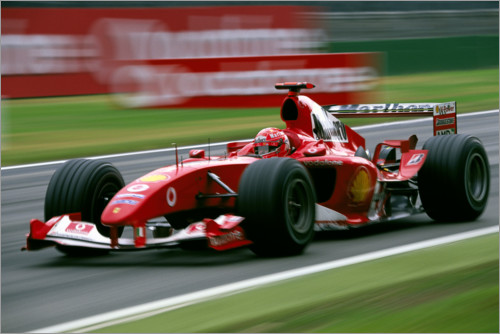

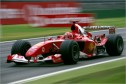

In [5]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2_imshow(imgsmall)

## Distance from Pixels to Cluster



We'll begin by writing code to compute the distance from each pixel to a cluster center.


In [12]:
# img is an rxcx3 array.  
# cl is a 1x3 array, containing the rgb values of a cluster center.
# The function returns a rxc array, in which each entry gives the squared
# distance from the corresponding pixel to cl.

def cluster_points_distance_squared(cl, img):
  x,y,z = img.shape
  distances = np.empty((x,y))
  
  for i in range(x):
    for j in range(y):
      distances[i][j] = np.sum((img[i][j] - cl)**2)

  return distances

Just to test this, here's the output of the code on a simple problem:

In [10]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [1,0,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,0,1]
testim[1,1,0:3] = [1,1,1]
cl = np.array([1,0,1])
cluster_points_distance_squared(cl, testim)


array([[1., 3.],
       [1., 1.]])

Expected Result:  
[[1, 3],[1, 1]]

## Assigning Pixels to Clusters


This function decides what cluster each pixel belongs to. It computes the distance from each cluster center to each pixel, and assigns each pixel to the nearest cluster.  One edge case that can arise is when a pixel is equidistant to two or more cluster centers and I will be dealing with it by assigning it to the cluster that appears first in the list of clusters.

In [13]:
# cls is a list of cluster centers.  Every item in cls is a 1x3 array indicating the center of a cluster
# img is an image, represented as a rxcx3 array.
# The function returns an rxc array.  Each entry in the array is an integer
# giving the index of the cluster that the corresponding pixel belongs to.

def cluster_members(cls, img): 
  
  x,y,z = img.shape
  distances = np.empty((x,y,len(cls)))
  closest_cluster = np.empty((x,y))

  for a in range(x):
    for b in range(y):
      for i in range(len(cls)):
        distances[a][b][i] = np.sum((img[a][b] - cls[i])**2)
  

  for a in range(x):
    for b in range(y):
      closest_cluster[a][b] = np.argmin(distances[a][b])


  return closest_cluster

Again just to test this, here's the output of the code on a simple problem:

In [19]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [1,1,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,1,1]
testim[1,1,0:3] = [0,0,1]
cl0 = np.array([.3,.8,0])
cl1 = np.array([0, .1, .8])
cls = [cl0, cl1]

asgn = cluster_members(cls, testim)
asgn


array([[0., 0.],
       [1., 1.]])

Expected Result:

[[0, 0],[1, 1]]

## Updating Clusters


This function will update the centers of the clusters, based on cluster assignments that have been computed. Each cluster center is updated to be the average of the pixels assigned to that center.

An edge case here is that a cluster has no pixels assigned to it. In this case, I will assign the cluster with a center of [-255,-255,-255]. This way no pixels will be assigned to it in the future.

In [15]:
# asgn contains an image-sized 2D array containing the index of the clusters 
# that each pixel is assigned to (the output of cluster_members function).
# k is the number of cluster centers.
# The functions return a list of cluster centers. Each center is a 1x3 array.

def update_centers(asgn, img, k):

  x,y,z = img.shape
  average = np.zeros((k,3))

  for a in range(x):
    for b in range(y):
      for i in range(k):
        if asgn[a][b] == i:
          average[i][0] += img[a][b][0]
          average[i][1] += img[a][b][1]
          average[i][2] += img[a][b][2]

  for i in range(k):
    count = np.count_nonzero(asgn == i)
    if count == 0:
      average[i] = [-255,-255,-255]
    else:
      average[i] /= count

  return average

Again, we'll try this on a simple example, using the results from the last example:

In [21]:
cls = update_centers(asgn, testim, 2)
cls



array([[0.5, 1. , 0. ],
       [0. , 0.5, 1. ]])

Expected Result:
[[0.5,1,0],[0,0.5,1]]

## Initialization

This function takes as input the initial values of the clusters which it uses to computes the final cluster centers and the final assignments of pixels to clusters using the cluster_members and update_centers functions.

In [16]:
# cls is a list of arrays containing the initial cluster centers.
# n is the number of iterations.
# It returns a list of the final cluster centers and the final assignments of 
# pixels to clusters as a tuple.

def initialized_k_means(cls, img, n):
  
  for i in range(n):
    asgn = cluster_members(cls, img)
    cls = update_centers(asgn, img, len(cls))

  return cls, asgn

Testing on a simple example:

In [17]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [0,0,0]
testim[0,1,0:3] = [2,0,0]
testim[1,0,0:3] = [6,0,0]
testim[1,1,0:3] = [8,0,0]
cl0 = np.array([1,0,0])
cl1 = np.array([8, 6, 0])
cls = [cl0, cl1]
cls1, asgn1 = initialized_k_means(cls, testim, 1)
print(cls1)
print(asgn1)
cls2, asgn2 = initialized_k_means(cls, testim, 2)
print(cls2)
print(asgn2)

[[2.66666667 0.         0.        ]
 [8.         0.         0.        ]]
[[0. 0.]
 [0. 1.]]
[[1. 0. 0.]
 [7. 0. 0.]]
[[0. 0.]
 [1. 1.]]


Expected Result:

[[2.66666667,0,0],[8,0,0]]
[[0,0][0,1]]
[[1,0,0],[7,0,0]]
[[0,0][1,1]]

## Image Compression

The simple_init function initializes the cluster centers. And the compare_images function measures how close the compressed image is from the original image to measure performance of the algorithm.

In [24]:
# Returns a list of k classes.
def simple_init(k):
  np.random.seed(42)
  cls = [];
  for i in range(k):
    cls += [np.random.randint(0,256,3)]
  return cls

#Returns a Benchmark Score for the new image (the lower the better)
def compare_images(img1, img2):
  return np.sqrt(np.sum((img1-img2)**2))


The quantize_image function uses k-means algorithm to identify clusters for the original image and returns a new compressed image.

In [25]:
# This function takes an image, img, a number of cluster, k, and a number of iterations, n.
# It returns a new image and a list of the cluster centers as a tuple.
def quantize_image(img, k, n):

  x,y,z = img.shape
  cls = simple_init(k)
  cls = np.array(cls)
  image = np.empty([x,y,z])
  
  cls, asgn = initialized_k_means(cls,img,n)
  asgn = asgn.astype(int)
  cls = cls.astype(int)

  for i in range(x):
    for j in range(y):
      image[i,j,0:3] = cls[asgn[i][j]]

  return image, cls
  pass

Running this function on the image, we can see that when we use 256 colors, we get something that looks pretty similar to the original image.  With 8 colors, there are noticeable artifacts, but we have a comprehensible image.  This might be useful for very compact thumbnails or image icons.

Original Image:


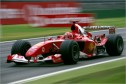

Compressed Image:
3643.6715000120416


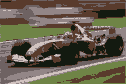

In [31]:
qimgsmall8, cls8 = quantize_image(imgsmall, 8, 10)
# qimgsmall256, cls256 = quantize_image(imgsmall, 256, 10)
print("Original Image:")
cv2_imshow(imgsmall) 
print("Compressed Image:")
print(compare_images(imgsmall, qimgsmall8))
cv2_imshow(qimgsmall8)
# cv2_imshow(qimgsmall256)
# print(compare_images(imgsmall, qimgsmall256))

## Further Improving Results Through K-means++

Using K-means++ algorithm to initialize clusters by chosing them uniformly at random from the pixels that are to be clustered. This helps spread out the initial k cluster centers and leads to the algorithm converging much quicker.   

In [28]:
def helper(cl, img):
  distance = np.sum((img - cl)**2)
  return distance
  pass

def better_quantize_image(img, k, n):
  
  x,y,z = img.shape
  cls = np.zeros([1,3])
  cls[0] = img[0,0]
  distances = np.empty((x,y))

  for i in range(k-1):
    ccls = cluster_members(cls, img)
    ccls = ccls.astype(int)
    for a in range(x):
      for b in range(y):
        distances[a][b] = helper(cls[ccls[a][b]],img[a][b])
    r, s = np.unravel_index(distances.argmax(), distances.shape)
    cls = np.vstack([cls,img[r][s]])

  image = np.empty([x,y,z])
  cls, asgn = initialized_k_means(cls,img,n)
  asgn = asgn.astype(int)
  cls = cls.astype(int)

  for i in range(x):
    for j in range(y):
      image[i,j,0:3] = cls[asgn[i][j]]
  image = image.astype(np.uint8)

  return image, cls

Testing the performance of K-means against K-means++:

Original Image:


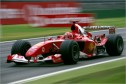

K-means:
2851.8832374415333


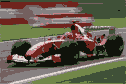

K-means++:
1529.7339637989346


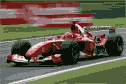

In [30]:

qimgsmall1, cls1 = quantize_image(imgsmall, 16, 10)
qimgsmall2, cls2 = better_quantize_image(imgsmall, 16, 10)
print("Original Image:")
cv2_imshow(imgsmall) 
print("K-means:")
print(compare_images(imgsmall, qimgsmall1))
cv2_imshow(qimgsmall1)
print("K-means++:")
print(compare_images(imgsmall, qimgsmall2))
cv2_imshow(qimgsmall2)